In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os,gc,re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]


from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/iee-fraud detection')

In [5]:
df_train = pd.read_csv('data/train_combined.csv')
df_test = pd.read_csv('data/test_combined.csv')

In [6]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]

v_cols_included = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']



In [7]:
# droping v cols 
drop_cols = [col for col in df_train.columns if col[0] == 'V' and col not in v_cols_included]

print(f'dropping {len(drop_cols)} columns')
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

dropping 211 columns


In [8]:
## Train and test split¶
y_train = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


94

In [9]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [9]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])

### FFS on Normalized D cols

In [9]:
def model(x_train,y_train,cols):
    idx_train = x_train.index[:int(x_train.shape[0]*0.75)]  
    idx_validation = x_train.index[int(x_train.shape[0]*0.75):]
    
    print(f'fitting model on {len(current_cols)} columns')
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
          )
    model = clf.fit(x_train.loc[idx_train,cols], y_train[idx_train], 
            eval_set=[(x_train.loc[idx_validation,cols],y_train[idx_validation])],
            verbose=50, early_stopping_rounds=100)
    del clf
    return model.best_score

In [10]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    X_train['D'+str(i)+'n'] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)+'n'] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)


In [13]:
# Scaling numeric features
cols = [col for col in X_train.columns if col not in rem_cols]
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [14]:
del df_train,df_test

In [16]:
d_norm_cols = ['D'+str(i)+'n' for i in range(1,16)]
d_cols = ['D'+str(i) for i in range(1,16)]
old_cols = [col for col in X_train.columns if col not in rem_cols and col not in d_norm_cols]
len(old_cols)

220

In [18]:
len_new_cols = 16
best_cols = []
best_score = 0.9231
iteration = 1


while iteration < len_new_cols:
    for i in range(15):
        print(f'Added new column {d_norm_cols[i]}')
        if d_norm_cols[i] not in best_cols:
            current_cols = old_cols.copy()
            # adding and removing Di
        
            best_cols.append(d_norm_cols[i])
            
            print(f'working with {best_cols}')

            current_cols.extend([c for c in best_cols])

            for c in best_cols:
              if c[:-1] in current_cols:  #if D1 in current cols
                current_cols.remove(c[:-1])

            
            print('--'*40)
            current_score = model(X_train,y_train,current_cols)

            if current_score > best_score:
                print(f'score improved on adding {d_norm_cols[i]} new best score {current_score}')
                iteration_best_col = d_norm_cols[i]
                best_score = current_score

            else:
                current_cols.remove(d_norm_cols[i])
                current_cols.append(d_norm_cols[i][:-1])

            best_cols.remove(d_norm_cols[i])
        else:
          print(f'Column {d_norm_cols[i]} already present')    

    
    iteration += 1
    if iteration_best_col is not None:
        best_cols.append(iteration_best_col)
        iteration_best_col = None
        print(f'Best col in this iteration {iteration_best_col}, current best cols {best_cols}, score {best_score}')
                  
    else:
        print('None of the columns improving the score in this iteration')
        break
    print('###'*40)



Added new column D1n
working with ['D1n']
--------------------------------------------------------------------------------
fitting model on 220 columns
[0]	validation_0-auc:0.814009
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.869842
[100]	validation_0-auc:0.881214
[150]	validation_0-auc:0.892989
[200]	validation_0-auc:0.903839
[250]	validation_0-auc:0.911812
[300]	validation_0-auc:0.918888
[350]	validation_0-auc:0.923138
[400]	validation_0-auc:0.925631
[450]	validation_0-auc:0.92717
[500]	validation_0-auc:0.927371
[550]	validation_0-auc:0.927882
[600]	validation_0-auc:0.927957
[650]	validation_0-auc:0.928327
[700]	validation_0-auc:0.928206
Stopping. Best iteration:
[633]	validation_0-auc:0.928476

score improved on adding D1n new best score 0.928476
Added new column D2n
working with ['D2n']
--------------------------------------------------------------------------------
fitting model on 220 columns
[0]	validation_0-auc:0.816656
Will train un

In [ ]:
 gc.collect()

## Local cv

In [10]:
norm_cols = [15, 4, 2, 11, 10]
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in norm_cols:
      X_train['D'+str(i)+'n'] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
      X_test['D'+str(i)+'n'] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

In [11]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
rem_cols.extend(['D'+str(i) for i in norm_cols])
cols = [col for col in X_train.columns if col not in rem_cols]

In [12]:
# Scaling numeric features

for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff


In [13]:
# 75-25 split
#0.934
idx_train = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
    )
model = clf.fit(X_train.loc[idx_train,cols], y_train[idx_train], 
    eval_set=[(X_train.loc[idx_validation,cols],y_train[idx_validation])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.818308
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.870492
[100]	validation_0-auc:0.885002
[150]	validation_0-auc:0.898513
[200]	validation_0-auc:0.908753
[250]	validation_0-auc:0.917029
[300]	validation_0-auc:0.922625
[350]	validation_0-auc:0.926551
[400]	validation_0-auc:0.929177
[450]	validation_0-auc:0.930719
[500]	validation_0-auc:0.931364
[550]	validation_0-auc:0.931993
[600]	validation_0-auc:0.932278
[650]	validation_0-auc:0.932684
[700]	validation_0-auc:0.932727
[750]	validation_0-auc:0.932621
[800]	validation_0-auc:0.932511
Stopping. Best iteration:
[733]	validation_0-auc:0.932799



In [14]:
del df_train,df_test

Area under train roc 0.997071106720153
Area under test roc 0.932798870177741


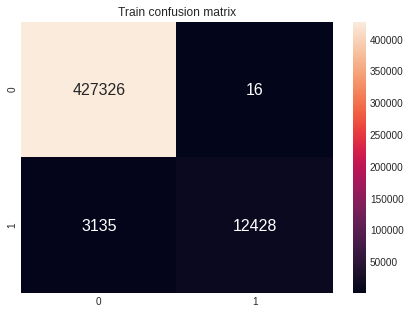

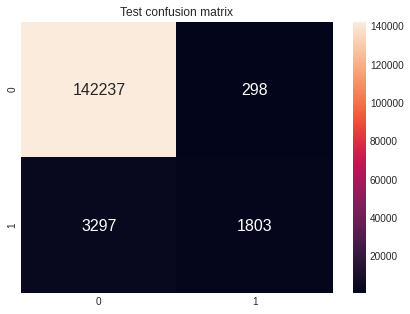

In [15]:

x_train = X_train[cols]
y_train_pred = model.predict(x_train.iloc[idx_train])
y_test_pred = model.predict(x_train.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(y_train.iloc[idx_train], model.predict_proba(x_train.iloc[idx_train])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.iloc[idx_validation], model.predict_proba(x_train.iloc[idx_validation])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


train_cf = confusion_matrix(y_train.iloc[idx_train],y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_train.iloc[idx_validation],y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

In [17]:
x_test = X_test[cols]
y_pred_test = model.predict_proba(x_test)[:,1]
submission = pd.read_csv('data/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('submission.csv',index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.001836
1,3663550,0.002456
2,3663551,0.004309
3,3663552,0.002348
4,3663553,0.010030


# Local CV: 0.9327
# Private leaderboard: 0.907181
# Public leaderboard: 0.930595
